# Using Data Science to prevent delays on your flights

In this notebook I approach some questions related to the opening of faults in a Latin American Airline Company, where we have all the critical faults that have been active through 2019.

Key Business Questions:
   1. Which fleet has more faults per aircrafts?
   2. How the aircraft age relates to the process of opening a fault?
   3. Which ATA has more faults?
   4. Heavy Maintenance Check impacts on how many faults are open?  
   5. Where most faults were opened?


## Step 1: Import All Relevant Libraries

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from io import StringIO
%matplotlib inline


## Step 2: Importing and understading the Dataset

In [2]:
df = pd.read_csv(r'C:\Users\Larissa\Downloads\data_test.csv',encoding='latin-1')

df.head()

,aircraft_tail,check_c_in_lst_yr,aircraft_years,aircraft_msn,fault_source,deferral_reference,deferral_class,logbook_type,event_type,event_status,...,moc,maintenance_airline_code,maintenance_airline_code_group,fleet,fleet_type,fleet_holding,condicion_mapi,type,type_latam,fault_count
0,PR-MBW,no,11,3710,CABIN,35-30-01A,MEL C,CABIN,CF,CFCERT,...,NaN,A319JJ,A320JJ,A320FAM,NB,BR,LIMPIO,NO TECH,NO TECH,-
1,PT-MZZ,no,19,1593,PILOT,46-21-01A,MEL C,MAINT,CF,CFCERT,...,NaN,A320JJ,A320JJ,A320FAM,NB,BR,LIMPIO,TECH,TECH,FAULT
2,PT-MXL,no,6,5947,PILOT,21-00-04A,MEL C,MAINT,CF,CFCERT,...,NaN,A321JJ,A320JJ,A320FAM,NB,BR,LIMPIO,TECH,TECH,FAULT
3,PR-MBO,yes,13,3156,PILOT,33-40-01B,MEL C,NaN,CF,CFCERT,...,NaN,A320JJ,A320JJ,A320FAM,NB,BR,LIMPIO,TECH,TECH,REPEATED
4,PR-MBZ,no,18,1827,PILOT,36-12-02B,MEL C,MAINT,CF,CFCERT,...,NaN,A320JJ,A320JJ,A320FAM,NB,BR,LIMPIO,TECH,TECH,REPEATED


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15937 entries, 0 to 15936
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   aircraft_tail                   15937 non-null  object 
 1   check_c_in_lst_yr               15937 non-null  object 
 2   aircraft_years                  15937 non-null  int64  
 3   aircraft_msn                    15937 non-null  int64  
 4   fault_source                    15937 non-null  object 
 5   deferral_reference              15933 non-null  object 
 6   deferral_class                  15937 non-null  object 
 7   logbook_type                    13426 non-null  object 
 8   event_type                      15937 non-null  object 
 9   event_status                    15937 non-null  object 
 10  fault_name                      15937 non-null  object 
 11  description                     15351 non-null  object 
 12  barcode                         

In [4]:
df.describe()

,aircraft_years,aircraft_msn,ata_2d,ata_4d,ata_6d,moc
count,15937.000000,15937.000000,15937.000000,15937.000000,15937.000000,1.0
mean,10.923574,8413.483466,32.039593,3212.785154,321280.076614,345995.0
std,4.856661,12270.757021,11.968505,1215.818329,121581.291955,NaN
min,0.000000,24.000000,0.000000,40.000000,4000.000000,345995.0
25%,7.000000,2014.000000,25.000000,2500.000000,250000.000000,345995.0
50%,11.000000,4171.000000,29.000000,2846.000000,284600.000000,345995.0
75%,13.000000,6409.000000,35.000000,3500.000000,350000.000000,345995.0
max,20.000000,42214.000000,80.000000,8013.000000,801300.000000,345995.0


## Step 3: Data Preparation

### Data Cleaning: The columns below don't presented any relevant information to our analysis

In [5]:
df=df.drop(['aircraft_msn','deferral_reference','event_type','found_during_flight','aircraft_assembly','config_slot_details','maintenance_airline_code','maintenance_airline_code_group','fleet_type','fleet_holding','type','type_latam','moc'],axis=1)
df.head()

,aircraft_tail,check_c_in_lst_yr,aircraft_years,fault_source,deferral_class,logbook_type,event_status,fault_name,description,barcode,task_status,flight_arrival_airport,ata_2d,ata_4d,ata_6d,config_slot_name,fleet,condicion_mapi,fault_count
0,PR-MBW,no,11,CABIN,MEL C,CABIN,CFCERT,501173-B-047 REF ITEM RTC BA 652698 - UTILIZAD...,501173-B-047 REF ITEM RTC BA 652698 - UTILIZAD...,T00F8Y6K,COMPLETE,CNF,35,3530,353000,PORTABLE OXYGEN,A320FAM,LIMPIO,-
1,PT-MZZ,no,19,PILOT,MEL C,MAINT,CFCERT,500928-A-037 HORARIO PUSHBACK ACARS INCORRETO ...,HORARIO PUSHBACK ACARS INCORRETO + 5MINUTOS,T00F8Y94,COMPLETE,FLN,46,4621,462100,AIR TRAFFIC INFORMATION MANAGMENT SYSTEM (A.T....,A320FAM,LIMPIO,FAULT
2,PT-MXL,no,6,PILOT,MEL C,MAINT,CFCERT,500995-A-029 MAINTENANCE TEMP CTL 1 AND 2,MAINTENANCE TEMP CTL 1 AND 2 \r\nPERFORMED B...,T00F93J0,COMPLETE,BSB,21,2161,216100,PACK TEMPERATURE CONTROL,A320FAM,LIMPIO,FAULT
3,PR-MBO,yes,13,PILOT,MEL C,NaN,CFCERT,MLB 501345-A-004 NAV TAIL LIGHT 1 INOP,NAV TAIL LIGHT 1 INOP,T00F9E5G,COMPLETE,GIG,33,3341,334100,NAVIGATION LIGHTS,A320FAM,LIMPIO,REPEATED
4,PR-MBZ,no,18,PILOT,MEL C,MAINT,CFCERT,AIR APU BLEED FAULT STUKED IN OPEN POSITION ON...,AIR APU BLEED FAULT STUKED IN OPEN POSITION ON...,T00F9KH4,COMPLETE,GRU,49,4951,495100,BLEED AND SURGE AIR,A320FAM,LIMPIO,REPEATED


### Check and impute missing values

In [6]:
def missing_values_table(df):
    '''
    Input - Dataframe that has all relevant variables for consideration.
    
    Output - Displays the total number of variables/columns in the dataset. In addition, it also 
    generates count of missing values for each column.
    
    '''    
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
    "There are " + str(mis_val_table_ren_columns.shape[0]) +
    " columns that have missing values.")
    return mis_val_table_ren_columns
    
df_qa=missing_values_table(df)
df_qa

Your selected dataframe has 19 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
logbook_type,2511,15.8
flight_arrival_airport,1644,10.3
description,586,3.7


Here there's a important point about the missing data in the column "flight_arrival_airport". If it's null it's means that the fault was opened during a period of time where the aircraft wasn't flying, so in those cases I'll drop any row with missing value because they don't help with our analysis.

The column "description" has some NaN values but analyzing the table we see that the column "fault_name" has the same information and no null data, so we are going to drop it as well.

In [7]:
df=df[df['flight_arrival_airport'].notna()]
df=df[df['description'].notna()]

The column with most missing values is"logbook_type", we are going to fill this column data based on the rule below:

In [45]:
df['logbook_type'] = df['logbook_type'].fillna(0)

I wasn't expecting that many values being null in that column, this information does not impact our analysis all that much right now, but it shows a flaw in the process of opening faults, since **15%** of the faults weren't registered correctly. It's not much help to answer our questions but I really think that it's nice insight that can change the quality of the process.


# Step 4: Analysis and Visualization

## Question 1: What is the fleet with most open faults per aircrafts?

How does the four main fleets behave in terms of faults per amount of airplanes? Do they have the same rate of faults or does one fleet stands out of the others? To answer theses questions, I going to use some graphs visualization.

fleet
A320FAM    129
A350         8
B767        13
B777        10
Name: aircraft_tail, dtype: int64

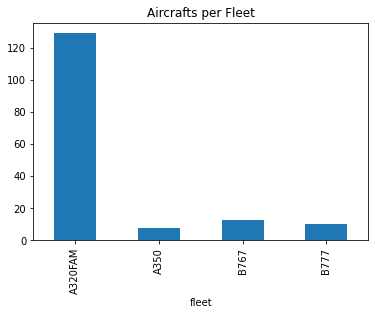

In [31]:
#count and visualize the total of aircrafts per fleet
acft_per_fleet = df.groupby(['fleet'])['aircraft_tail'].nunique()
acft_per_fleet[:4].plot(kind='bar')
plt.title('Aircrafts per Fleet')
acft_per_fleet

The A320FAM fleet is by far the biggest fleet in the company.

fleet
A320FAM    11717
A350         564
B767        1061
B777         531
Name: barcode, dtype: int64

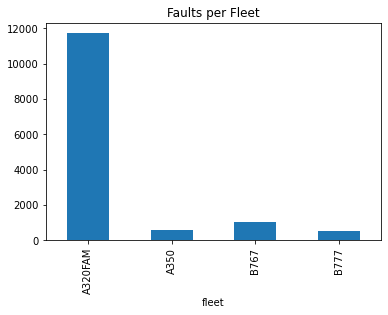

In [32]:
#count and visualize the total of faults per fleet
fault_per_fleet = df.groupby(['fleet'])['barcode'].nunique()
fault_per_fleet[:4].plot(kind='bar')
plt.title('Faults per Fleet')
fault_per_fleet

And as expected the A320FAM has more faults then the other fleets due to it's size, but we need to know how many faults per aircrafts each fleet presents.

fleet
A320FAM    90.829457
A350       70.500000
B767       81.615385
B777       53.100000
dtype: float64

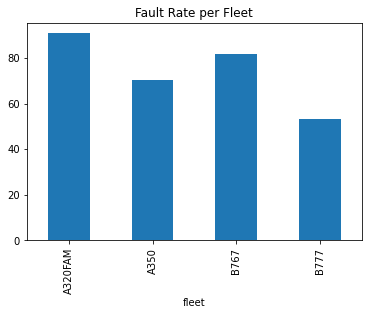

In [39]:
#count and visualize the rate of faults per fleet
rate_fleet = fault_per_fleet/acft_per_fleet
rate_fleet[:4].plot(kind='bar')
plt.title('Fault Rate per Fleet')
rate_fleet


Now we have a number that it's fair to the difference between fleets sizes. The fleet with the biggest rate it's the A320FAM and the fleet with the lowest rate it's the B777.

# Question 2: How does the aircarft age relates to the faults?

Does older aircrafts open more faults? To answer this question, I used mainly two columns:

     - Barcode, to count the amount of faults
     - aircraft_years, the amount of years that a certain aircraft is operating.

In [46]:
dff = df.groupby('aircraft_tail') \
       .agg({'barcode':'count', 'aircraft_years':'mean'}) \
       .rename(columns={'barcode':'faults','aircraft_years':'acft_age'}) \
       .reset_index()
dfs = dff.sort_values('faults', ascending = False)
dfs

,aircraft_tail,faults,acft_age
1,PR-MAK,146,18
11,PR-MBG,145,19
34,PR-MHW,142,11
148,PT-XPD,141,5
113,PT-MXC,141,12
...,...,...,...
78,PR-XBE,16,0
79,PR-XBF,4,0
72,PR-TYU,3,0
73,PR-TYV,2,0


Text(0.5, 1.0, 'Faults x Age')

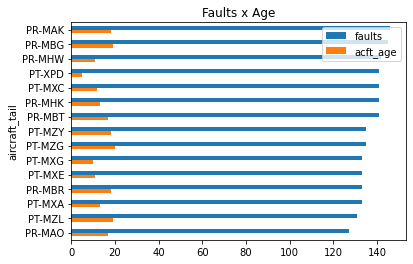

In [65]:
dfs[:15].plot(kind='barh', x='aircraft_tail')
plt.gca().invert_yaxis()
plt.title('Faults x Age')



In [44]:
age_mean = df.groupby(['fleet'])['aircraft_years'].mean()
age_mean


fleet
A320FAM    11.444141
A350        4.416667
B767        9.702168
B777        8.794727
Name: aircraft_years, dtype: float64

In [66]:
dfs.describe()

,faults,acft_age
count,160.000000,160.000000
mean,86.706250,9.587500
std,32.271957,5.263363
min,1.000000,0.000000
25%,69.000000,7.000000
50%,88.000000,9.000000
75%,112.250000,12.250000
max,146.000000,20.000000


All the aircrafts with less than 1 year ranked in the bottom of the list, therefore newer aircrafts didn't presented as many faults as older aircrafts. There are exceptions, for example PT-XPD that has only 5 years but ranked fifth. But in general as older the aircraft gets the more faults it will have.

# Question 3: Which ATA has more faults?

ATA is a numbering system which is a common referencing standard for commercial aircraft documentation. This commonality permits greater ease of learning and understanding for pilots, aircraft maintenance technicians, and engineers alike. Analyzing the ATA will lead to know what system had more failures.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002554A9B7850>,
      dtype=object)

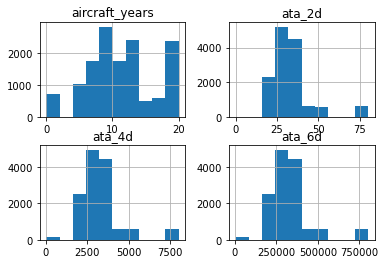

In [12]:
df.hist()

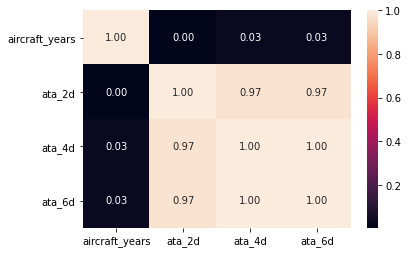

In [83]:
sns.heatmap(df.corr(), annot=True, fmt=".2f");

Text(0.5, 1.0, 'Top 10 ATA in 2019')

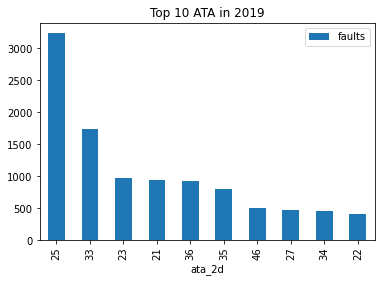

In [80]:
df_ata_2d = df.groupby('ata_2d') \
       .agg({'barcode':'count'}) \
       .rename(columns={'barcode':'faults'}) \
       .reset_index()
df_ata_2d = df_ata_2d.sort_values('faults', ascending = False)
df_ata_2d
df_ata_2d[:10].plot(kind='bar', x='ata_2d')
plt.title('Top 10 ATA in 2019')

The ATA 25 which refers to equipment and furnishings had the most faults in 2019.

# Question 4: Does a Heavy Maintenance Check impacts on how many faults are open?

Aircraft maintenance checks are periodic inspections that have to be done on all commercial and civil aircraft after a certain amount of time or usage. The C check is performed approximately every 20–24 months, or a specific number of actual flight hours (FH), or as defined by the manufacturer. This check puts the aircraft out of service for 1–2 weeks. The aircraft must not leave the maintenance site until it is completed. Does this Check, that should clean and make the aircraft better, is working?

In [183]:
df_check1 = df.pivot_table(df, index=['check_c_in_lst_yr'],columns=['fleet'])
df_check1

aircraft_years                                  ata_2d  \
fleet                    A320FAM      A350     B767      B777    A320FAM   
check_c_in_lst_yr                                                          
no                     11.192653  3.964856  9.72490  9.386598  32.007071   
yes                    11.690488  4.980080  9.68206  8.454006  31.862477   

                                                         ata_4d               \
fleet                   A350       B767       B777      A320FAM         A350   
check_c_in_lst_yr                                                              
no                 34.463259  33.136546  34.603093  3233.324595  2794.115016   
yes                34.195219  32.007105  30.875371  3218.080926  2901.350598   

                                                    ata_6d                 \
fleet                     B767         B777        A320FAM           A350   
check_c_in_lst_yr                                                           
no                 3343.664659  3488.716495  323334.063470  279414.079872   
yes                3228.884547  3119.973294  321809.537591  290137.474104   

                                                 
fleet                       B767           B777  
check_c_in_lst_yr                                
no                 334366.963855  348874.005155  
yes                322888.896980  311999.246291

In [185]:
check_c = df.groupby(['check_c_in_lst_yr'])['barcode'].nunique()
check_c

check_c_in_lst_yr
no     6803
yes    7070
Name: barcode, dtype: int64

Around 51% of the faults wew opened in aircrafts that had a Check in the last year, so we can conclude that the Check is not very effective to prevent faults.

# Question 5: Where do the most faults are open?

Many faults are simple tasks that can be made very quickly at the time that they are discovered, but to do that it’s necessary that the airport has the correct materials and tools.  
Discovering the airports where most faults are opened it’s possible to initiate a plan to provide the resources to complete the tasks.


In [131]:
df.pivot_table(index = 'flight_arrival_airport', columns = 'fleet')

aircraft_years                          ata_2d  \
fleet                         A320FAM     A350  B767  B777    A320FAM   
flight_arrival_airport                                                  
AJU                         10.238095      NaN   NaN   NaN  30.642857   
ANF                          0.000000      NaN   NaN   NaN  24.000000   
ASU                         15.918033      NaN   NaN   NaN  31.680328   
AUH                               NaN      NaN   NaN  11.0        NaN   
BCN                               NaN  4.44186  9.96   NaN        NaN   
...                               ...      ...   ...   ...        ...   
UDI                         13.950000      NaN   NaN   NaN  29.975000   
UNA                         15.666667      NaN   NaN   NaN  25.000000   
VCP                         10.066667      NaN   NaN   NaN  34.177778   
VIX                         13.195122      NaN   NaN   NaN  30.164634   
VVI                         17.250000      NaN   NaN   NaN  41.000000   

                                                     ata_4d               \
fleet                        A350   B767  B777      A320FAM         A350   
flight_arrival_airport                                                     
AJU                           NaN    NaN   NaN  3103.285714          NaN   
ANF                           NaN    NaN   NaN  2423.000000          NaN   
ASU                           NaN    NaN   NaN  3202.032787          NaN   
AUH                           NaN    NaN  52.0          NaN          NaN   
BCN                     31.906977  28.64   NaN          NaN  2086.093023   
...                           ...    ...   ...          ...          ...   
UDI                           NaN    NaN   NaN  3036.450000          NaN   
UNA                           NaN    NaN   NaN  2542.000000          NaN   
VCP                           NaN    NaN   NaN  3454.555556          NaN   
VIX                           NaN    NaN   NaN  3049.975610          NaN   
VVI                           NaN    NaN   NaN  4131.500000          NaN   

                                                ata_6d                 \
fleet                      B767    B777        A320FAM           A350   
flight_arrival_airport                                                  
AJU                         NaN     NaN  310330.642857            NaN   
ANF                         NaN     NaN  242300.000000            NaN   
ASU                         NaN     NaN  320203.877049            NaN   
AUH                         NaN  5271.0            NaN            NaN   
BCN                     2896.38     NaN            NaN  208609.302326   
...                         ...     ...            ...            ...   
UDI                         NaN     NaN  303646.350000            NaN   
UNA                         NaN     NaN  254200.000000            NaN   
VCP                         NaN     NaN  345460.177778            NaN   
VIX                         NaN     NaN  304999.042683            NaN   
VVI                         NaN     NaN  413150.000000            NaN   

                                             
fleet                        B767      B777  
flight_arrival_airport                       
AJU                           NaN       NaN  
ANF                           NaN       NaN  
ASU                           NaN       NaN  
AUH                           NaN  527100.0  
BCN                     289638.02       NaN  
...                           ...       ...  
UDI                           NaN       NaN  
UNA                           NaN       NaN  
VCP                           NaN       NaN  
VIX                           NaN       NaN  
VVI                           NaN       NaN  

[78 rows x 16 columns]

Text(0.5, 1.0, 'Top 20 Airports')

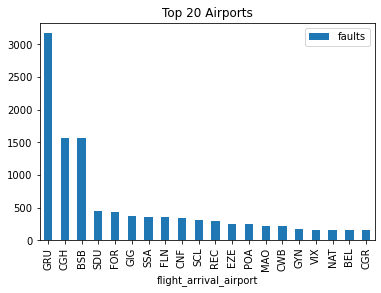

In [112]:
df_airport = df.groupby('flight_arrival_airport') \
       .agg({'barcode':'count'}) \
       .rename(columns={'barcode':'faults'}) \
       .reset_index()
df_airport = df_airport.sort_values('faults', ascending = False)

df_airport[:20].plot(kind='bar', x='flight_arrival_airport')
plt.title('Top 20 Airports')

In [162]:
df_airport.head()

,flight_arrival_airport,faults
26,GRU,3168.0
14,CGH,1568.0
10,BSB,1559.0
66,SDU,455.0
23,FOR,432.0


In [163]:
df_airport['faults'] = df_airport['faults'].astype(float)
print (df_airport.dtypes)

flight_arrival_airport     object
faults                    float64
dtype: object


In [165]:
total = df_airport.sum()['faults']

13873.0

Around 45% of the faults were opened in GRU, CGH and BSB, that makes sense since they are the 3 main HUB's in Brazil.